<a href="https://colab.research.google.com/github/Guilhos/InicCientifica/blob/main/SistemaEDORodrigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



$ \frac{d\dot{m}}{dt} = \frac{A_1}{L_C}(\phi (N(t), \dot{m})P_1 - P_P(t)) $

$ \frac{d P_P}{dt} = \frac{C_1^2}{\nu _P}(\dot{m}(t) - \alpha (t) K_\nu \sqrt{P_P - P_{out}}) $

$ \begin{matrix} A_1 & = & 2.6\centerdot 10^-3 m² \\
    \nu _P & = & 2.0 m³ \\
    L_C & = & 2.0 m \\
    K_\nu & = & \frac{0.38 kg}{(10^{-5}kBar)^{0.5}s} \\
    P_1 & = & 4.5 Bar \\
    P{out} & = & 5.0 Bar \end{matrix}
$

$ \frac{d\dot{m}}{dt} = \frac{2.6\centerdot 10^{-3}}{2.0}(1.5\centerdot 4.5 - P_P) $

$ \frac{d P_P}{dt} = \frac{479.029^2}{2.0}(\dot{m} - \alpha \centerdot {0.38} \centerdot \sqrt{P_P - 5.0}) $


In [1]:
!pip install casadi

from scipy.optimize import fsolve
import casadi as ca
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

### Variáveis

In [2]:
np.random.seed(42)

# Constantes
alpha0 = np.random.uniform(0.2, 0.8)
A1 = (2.6)*(10**-3)
Vp = 2
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

# Sistema de equações
def fun(variables, A1, Vp, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)*((1.5 * P1) - y)
    eqn_2 = (C**2)/Vp * (x - alpha0 * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]

# Condições Iniciais
result = fsolve(fun, (0, 10), args = (A1, Vp, Lc, kv, P1, P_out, C))
mFlowRate_init = result[0] # Mass Flow inicial
plenumPressure_init = result[1] # Plenum Pressure inicial

# Intervalos no tempo
interval = [np.linspace(i * 500, (i + 1) * 500, 500) for i in range(5)]

# Váriaveis CasADi
x = ca.MX.sym('x', 2) # Variáveis de Estado
alpha = ca.MX.sym('alpha', 1) # Parâmetro Alpha

# Listas para armazenar resultados
mFlowRate_values = []
plenumPressure_values = []
xRNN_values = []
alpha_values = [np.full(500, alpha0)]

### Integração

In [3]:
for i in range(0,5):
    if i == 0:
        alpha1 = alpha0
    else:
        alpha1 = np.random.uniform(0.2, 0.8)
        alpha_values.append(np.full(500, alpha1))

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/Vp * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])

    sol = F(x0 = [mFlowRate_init, plenumPressure_init], p = alpha1)

    xf_values = np.array(sol["xf"])
    xRNN_values.append(xf_values)
    mFlowRate_values.append(xf_values[0])
    plenumPressure_values.append(xf_values[1])

    # Atualizar as condições iniciais
    mFlowRate_init = xf_values[0][-1]
    plenumPressure_init = xf_values[1][-1]

### Plot

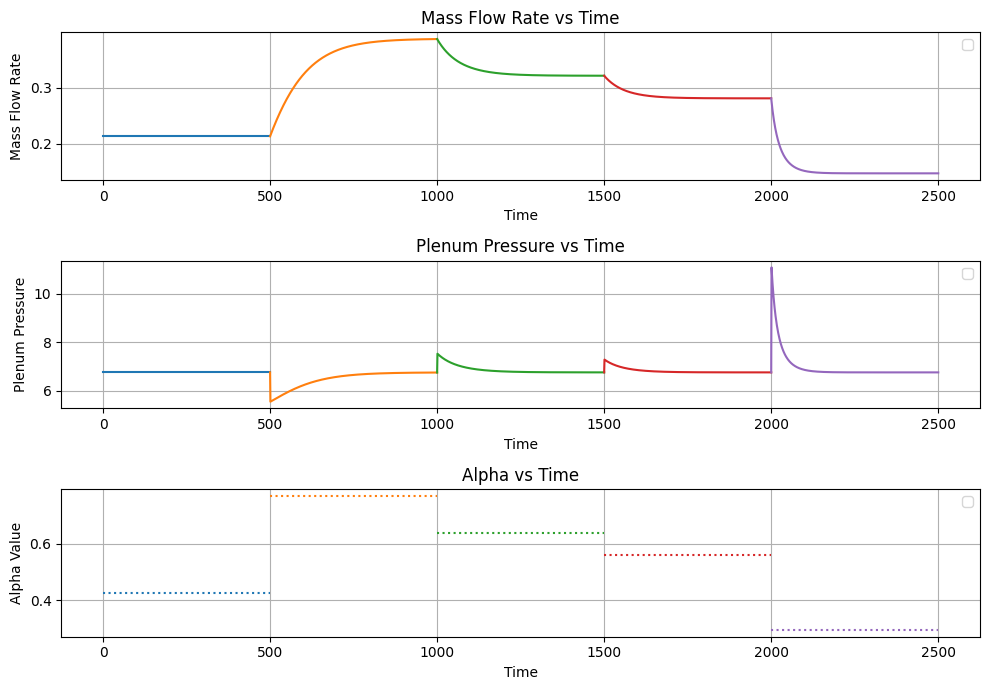

In [4]:
# Cria uma figura com subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 7))

# Gráfico da Taxa de Fluxo vs. Tempo
for i in range(0, 5):
    axs[0].plot(interval[i], np.squeeze(mFlowRate_values[i]))
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do Plenum vs. Tempo
for i in range(0, 5):
    axs[1].plot(interval[i], np.squeeze(plenumPressure_values[i]))
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

# Gráfico dos Valores de Alpha vs. Tempo
for i in range(0, 5):
    axs[2].plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
axs[2].grid(True)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Alpha Value')
axs[2].set_title('Alpha vs Time')
axs[2].legend()

# Ajusta o layout e exibe os gráficos
plt.tight_layout()
plt.show()


### RNN

In [23]:
xRNN_values = tf.convert_to_tensor(xRNN_values)
alpha_Tensor = tf.convert_to_tensor(alpha_values)

print(xRNN_values.shape, alpha_Tensor.shape)

timestep = 5

X = []
y = []
for i in range(len(xRNN_values[0][0])-timestep):
    X.append(xRNN_values[:,:,i])
    y.append(xRNN_values[:,:,i+timestep])

X = np.array(X)
y = np.array(y)

print(X.shape,y.shape)

model = keras.Sequential()

model.add(layers.LSTM(50,input_shape=(timestep, 2),return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2))

model.compile(optimizer='adam', loss = 'mean_squared_error')

history = model.fit(X, y, epochs=250, verbose = 0)



(5, 2, 500) (5, 500)
(495, 5, 2) (495, 5, 2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


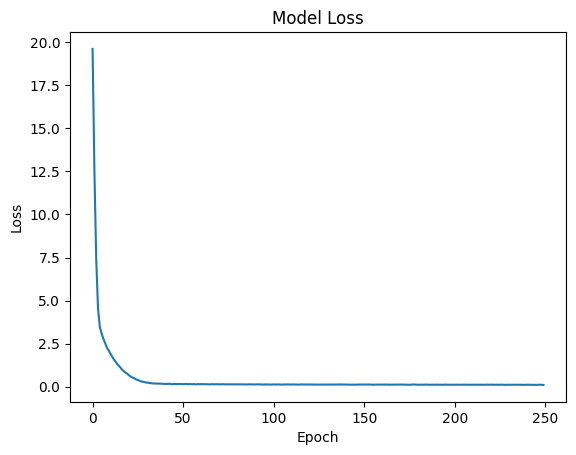

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


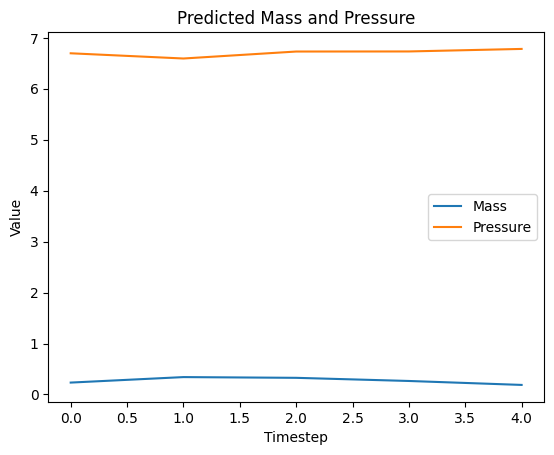

In [24]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Assuming X_new is the new data for prediction
prediction = model.predict(X)

# Extract mass and pressure from prediction
mass = prediction[0,:,0]
pressure = prediction[0,:,1]

# Plot mass and pressure
plt.plot(mass, label='Mass')
plt.plot(pressure, label='Pressure')
plt.title('Predicted Mass and Pressure')
plt.ylabel('Value')
plt.xlabel('Timestep')
plt.legend()
plt.show()